# Plant Leaf Disease Detection


## Imports

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from model_utility import plot_images

C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.__version__

'2.14.0'

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[]

In [4]:
tf.get_logger().setLevel('ERROR')

## Constants

### Data

In [5]:
BASE_DIR = r"C:\Users\dell\Downloads\archive (11)\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "valid")
TEST_DIR = os.path.join(BASE_DIR, "test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64

### Model

In [6]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

### Training

In [7]:
EPOCHS = 25
PATIENCE = 5
QUEUE_SIZE = 25
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200

## Data Loading

#### Train

In [8]:
total_train = 0

for d in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, d)
    img_count = len(os.listdir(path))
    total_train += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal training images: {total_train}')

Apple___Apple_scab                                 : 2016
Apple___Black_rot                                  : 1987
Apple___Cedar_apple_rust                           : 1760
Apple___healthy                                    : 2008
Blueberry___healthy                                : 1816
Cherry_(including_sour)___healthy                  : 1826
Cherry_(including_sour)___Powdery_mildew           : 1683
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 1642
Corn_(maize)___Common_rust_                        : 1907
Corn_(maize)___healthy                             : 1859
Corn_(maize)___Northern_Leaf_Blight                : 1908
Grape___Black_rot                                  : 1888
Grape___Esca_(Black_Measles)                       : 1920
Grape___healthy                                    : 1692
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         : 1722
Orange___Haunglongbing_(Citrus_greening)           : 2010
Peach___Bacterial_spot                             : 1838
Peach___health

#### Validation

In [9]:
total_val = 0

for d in os.listdir(VAL_DIR):
    path = os.path.join(VAL_DIR, d)
    img_count = len(os.listdir(path))
    total_val += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal validation images: {total_val}')

Apple___Apple_scab                                 : 504
Apple___Black_rot                                  : 497
Apple___Cedar_apple_rust                           : 440
Apple___healthy                                    : 502
Blueberry___healthy                                : 454
Cherry_(including_sour)___healthy                  : 456
Cherry_(including_sour)___Powdery_mildew           : 421
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 410
Corn_(maize)___Common_rust_                        : 477
Corn_(maize)___healthy                             : 465
Corn_(maize)___Northern_Leaf_Blight                : 477
Grape___Black_rot                                  : 472
Grape___Esca_(Black_Measles)                       : 480
Grape___healthy                                    : 423
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         : 430
Orange___Haunglongbing_(Citrus_greening)           : 503
Peach___Bacterial_spot                             : 459
Peach___healthy                

#### Test

In [10]:
test_image_data = []
test_image_filenames = []

for img_name in os.listdir(TEST_DIR):
    img = load_img(os.path.join(TEST_DIR, img_name), target_size = IMG_SHAPE)
    test_image_data.append(img_to_array(img, dtype = 'uint8'))
    test_image_filenames.append(img_name)
    print(img_name)
    
test_image_data = np.array(test_image_data)/255
print(f'\nTotal testing images: {len(test_image_data)}')

AppleCedarRust1.JPG
AppleCedarRust2.JPG
AppleCedarRust3.JPG
AppleCedarRust4.JPG
AppleScab1.JPG
AppleScab2.JPG
AppleScab3.JPG
CornCommonRust1.JPG
CornCommonRust2.JPG
CornCommonRust3.JPG
PotatoEarlyBlight1.JPG
PotatoEarlyBlight2.JPG
PotatoEarlyBlight3.JPG
PotatoEarlyBlight4.JPG
PotatoEarlyBlight5.JPG
PotatoHealthy1.JPG
PotatoHealthy2.JPG
TomatoEarlyBlight1.JPG
TomatoEarlyBlight2.JPG
TomatoEarlyBlight3.JPG
TomatoEarlyBlight4.JPG
TomatoEarlyBlight5.JPG
TomatoEarlyBlight6.JPG
TomatoHealthy1.JPG
TomatoHealthy2.JPG
TomatoHealthy3.JPG
TomatoHealthy4.JPG
TomatoYellowCurlVirus1.JPG
TomatoYellowCurlVirus2.JPG
TomatoYellowCurlVirus3.JPG
TomatoYellowCurlVirus4.JPG
TomatoYellowCurlVirus5.JPG
TomatoYellowCurlVirus6.JPG

Total testing images: 33


### Image Generators

#### Train

In [11]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 70295 images belonging to 38 classes.


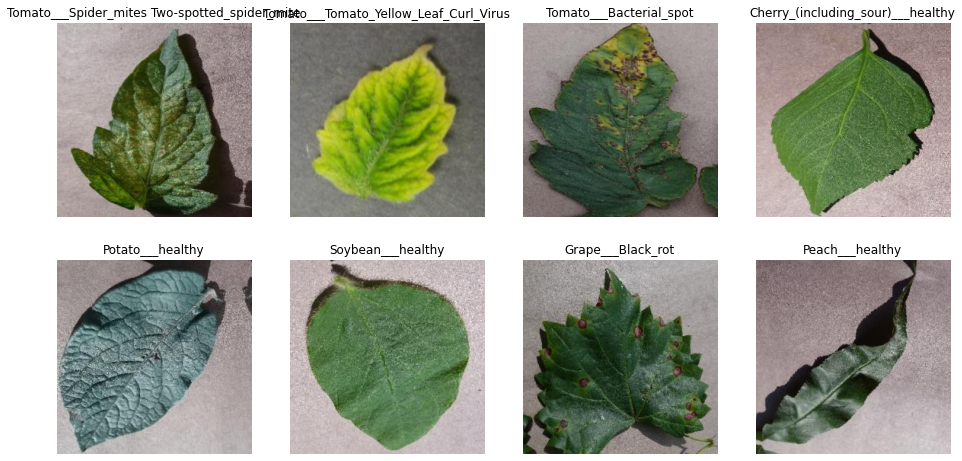

In [12]:
plot_images(train_data_gen)

#### Validation

In [13]:
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 17572 images belonging to 38 classes.


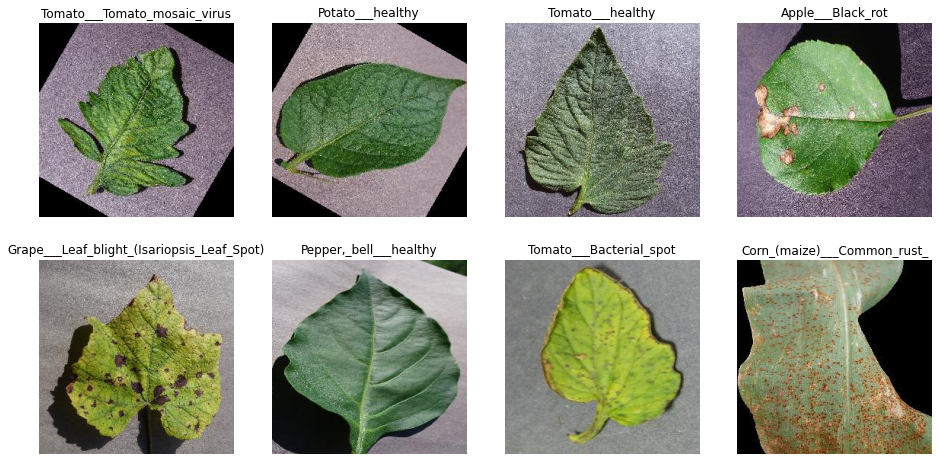

In [14]:
plot_images(val_data_gen)

### Class lookup dictionary

In [15]:
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 38


In [16]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Apple___Apple_scab
 1 : Apple___Black_rot
 2 : Apple___Cedar_apple_rust
 3 : Apple___healthy
 4 : Blueberry___healthy
 5 : Cherry_(including_sour)___Powdery_mildew
 6 : Cherry_(including_sour)___healthy
 7 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 8 : Corn_(maize)___Common_rust_
 9 : Corn_(maize)___Northern_Leaf_Blight
10 : Corn_(maize)___healthy
11 : Grape___Black_rot
12 : Grape___Esca_(Black_Measles)
13 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14 : Grape___healthy
15 : Orange___Haunglongbing_(Citrus_greening)
16 : Peach___Bacterial_spot
17 : Peach___healthy
18 : Pepper,_bell___Bacterial_spot
19 : Pepper,_bell___healthy
20 : Potato___Early_blight
21 : Potato___Late_blight
22 : Potato___healthy
23 : Raspberry___healthy
24 : Soybean___healthy
25 : Squash___Powdery_mildew
26 : Strawberry___Leaf_scorch
27 : Strawberry___healthy
28 : Tomato___Bacterial_spot
29 : Tomato___Early_blight
30 : Tomato___Late_blight
31 : Tomato___Leaf_Mold
32 : Tomato___Septoria_leaf_spot
33 

## Model

### Input Layer

In [17]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
inputs.shape

TensorShape([None, 256, 256, 3])

### Depthwise Convolution + Pointwise Convolution + Max Pooling blocks

#### Block 1

In [18]:
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu", name = "DwC_1")(inputs)
depth_conv_1.shape

TensorShape([None, 256, 256, 24])

In [19]:
point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
point_conv_1.shape

TensorShape([None, 256, 256, 32])

In [20]:
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)
max_pool_1.shape

TensorShape([None, 128, 128, 32])

#### Block 2

In [21]:
depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
depth_conv_2.shape

TensorShape([None, 128, 128, 32])

In [22]:
point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
point_conv_2.shape

TensorShape([None, 128, 128, 64])

In [23]:
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)
max_pool_2.shape

TensorShape([None, 64, 64, 64])

#### Block 3

In [24]:
depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
depth_conv_3.shape

TensorShape([None, 64, 64, 64])

In [25]:
point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
point_conv_3.shape

TensorShape([None, 64, 64, 128])

In [26]:
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)
max_pool_3.shape

TensorShape([None, 32, 32, 128])

#### Block 4

In [27]:
depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
depth_conv_4.shape

TensorShape([None, 32, 32, 128])

In [28]:
point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
point_conv_4.shape

TensorShape([None, 32, 32, 256])

In [29]:
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)
max_pool_4.shape

TensorShape([None, 16, 16, 256])

#### Block 5

In [30]:
depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
depth_conv_5.shape

TensorShape([None, 16, 16, 256])

In [31]:
point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
point_conv_5.shape

TensorShape([None, 16, 16, 512])

In [32]:
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)
max_pool_5.shape

TensorShape([None, 8, 8, 512])

### Global Average Pooling layers for each block

In [33]:
global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_1.shape

TensorShape([None, 32])

In [34]:
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_2.shape

TensorShape([None, 64])

In [35]:
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_3.shape

TensorShape([None, 128])

In [36]:
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_4.shape

TensorShape([None, 256])

In [37]:
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)
global_avg_5.shape

TensorShape([None, 512])

### Concatenation Layer

In [38]:
concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
concatenated.shape

TensorShape([None, 992])

### Dropout and Dense Layers

In [39]:
dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dropout_1.shape

TensorShape([None, 992])

In [40]:
dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1")(dropout_1)
dense_1.shape

TensorShape([None, 512])

In [41]:
dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dropout_2.shape

TensorShape([None, 512])

In [42]:
dense_2 = Dense(total_classes, activation = "softmax", name = "Output")(dropout_2)
dense_2.shape

TensorShape([None, 38])

### Model Summary

In [43]:
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "Plant_Leaf"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 DwC_1 (DepthwiseConv2D)     (None, 256, 256, 24)         120       ['Input[0][0]']               
                                                                                                  
 PwC_1 (Conv2D)              (None, 256, 256, 32)         800       ['DwC_1[0][0]']               
                                                                                                  
 MP_1 (MaxPooling2D)         (None, 128, 128, 32)         0         ['PwC_1[0][0]']               
                                                                                         

## Training

### Callbacks

In [44]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)

### History

In [45]:
%%time

history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    max_queue_size = QUEUE_SIZE,
    callbacks = [earlyStop, tensorBoard]
)

Epoch 1/25
1099/1099 [==============================] - 4279s 4s/step - loss: 2.6482 - accuracy: 0.2454 - val_loss: 2.6032 - val_accuracy: 0.3267
Epoch 2/25
1099/1099 [==============================] - 3729s 3s/step - loss: 1.3145 - accuracy: 0.5906 - val_loss: 1.7951 - val_accuracy: 0.5216
Epoch 3/25
1099/1099 [==============================] - 3730s 3s/step - loss: 0.8007 - accuracy: 0.7444 - val_loss: 0.9169 - val_accuracy: 0.7278
Epoch 4/25
1099/1099 [==============================] - 3719s 3s/step - loss: 0.5485 - accuracy: 0.8247 - val_loss: 1.0422 - val_accuracy: 0.7193
Epoch 5/25
1099/1099 [==============================] - 3725s 3s/step - loss: 0.4180 - accuracy: 0.8656 - val_loss: 0.8906 - val_accuracy: 0.7579
Epoch 6/25
1099/1099 [==============================] - 3773s 3s/step - loss: 0.3496 - accuracy: 0.8857 - val_loss: 0.6360 - val_accuracy: 0.8218
Epoch 7/25
1099/1099 [==============================] - 3725s 3s/step - loss: 0.2918 - accuracy: 0.9040 - val_loss: 0.8464 -

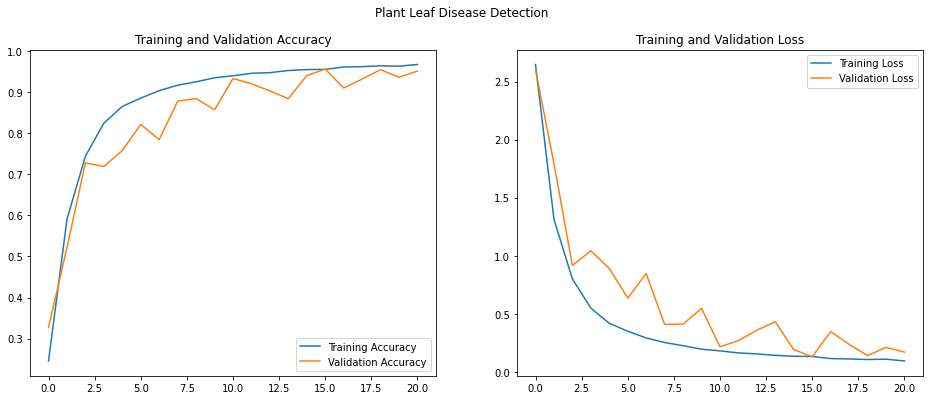

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Plant Leaf Disease Detection')

plt.savefig('acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Evaluation

### Evaluating Test data

In [47]:
test_pred = np.argmax(model.predict(test_image_data), axis = 1)
test_pred

2/2 [==============================] - 23s 33ms/step


array([ 2,  2,  2,  2,  5,  0,  0,  8,  8,  8, 20, 20, 20, 20, 20, 22, 22,
       29, 29, 29, 29, 29, 29, 37, 37, 37, 37, 35, 35, 35, 35, 35, 35],
      dtype=int64)

In [48]:
test_pred_classes = [class_name_lookup[i] for i in test_pred]

pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })

,Filename,Predicted classes
0,AppleCedarRust1.JPG,Apple___Cedar_apple_rust
1,AppleCedarRust2.JPG,Apple___Cedar_apple_rust
2,AppleCedarRust3.JPG,Apple___Cedar_apple_rust
3,AppleCedarRust4.JPG,Apple___Cedar_apple_rust
4,AppleScab1.JPG,Cherry_(including_sour)___Powdery_mildew
5,AppleScab2.JPG,Apple___Apple_scab
6,AppleScab3.JPG,Apple___Apple_scab
7,CornCommonRust1.JPG,Corn_(maize)___Common_rust_
8,CornCommonRust2.JPG,Corn_(maize)___Common_rust_
9,CornCommonRust3.JPG,Corn_(maize)___Common_rust_


### Visualizing test data predictions

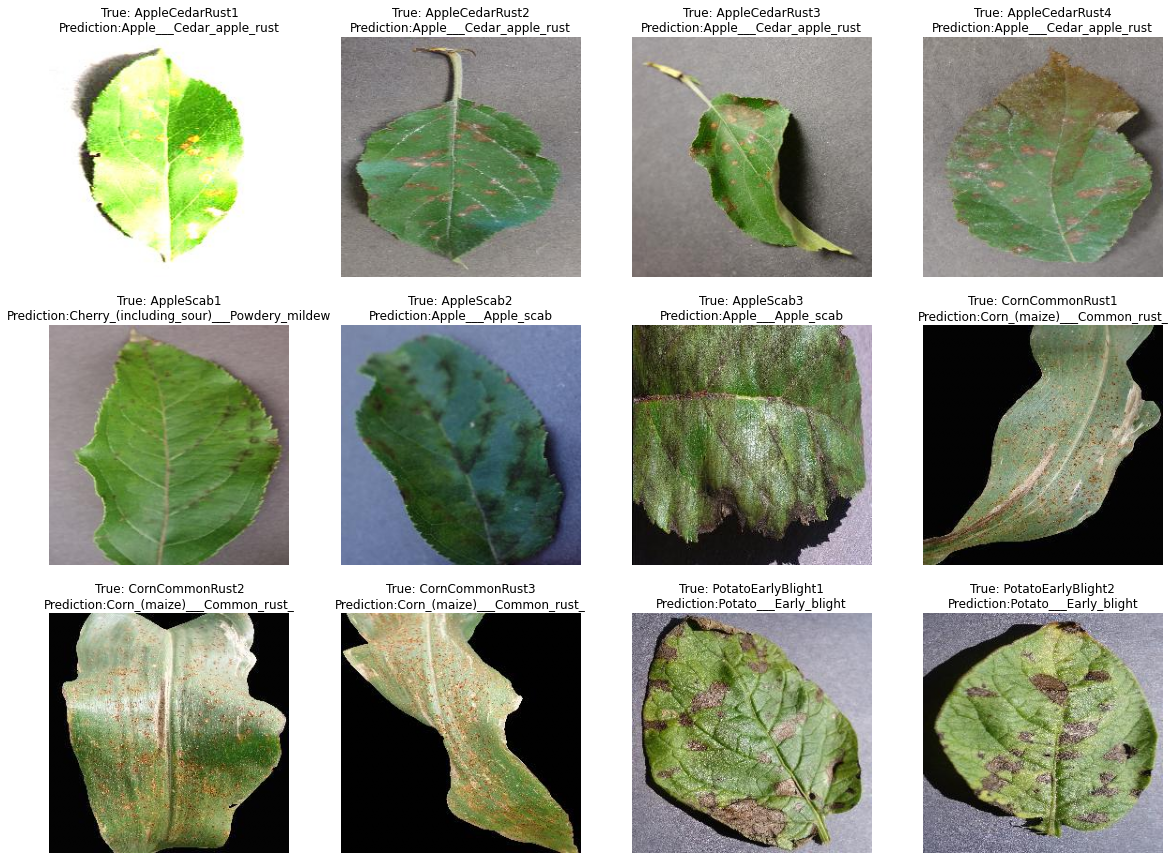

In [49]:
plt.subplots(nrows = 3, ncols = 4, figsize = (20, 15))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[i])
    plt.title(f"True: {test_image_filenames[i][:-4]}\nPrediction:{test_pred_classes[i]}")

plt.show()

### Confusion matrix for validation data

In [50]:
evaluation_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 17572 images belonging to 38 classes.


275/275 [==============================] - 244s 885ms/step


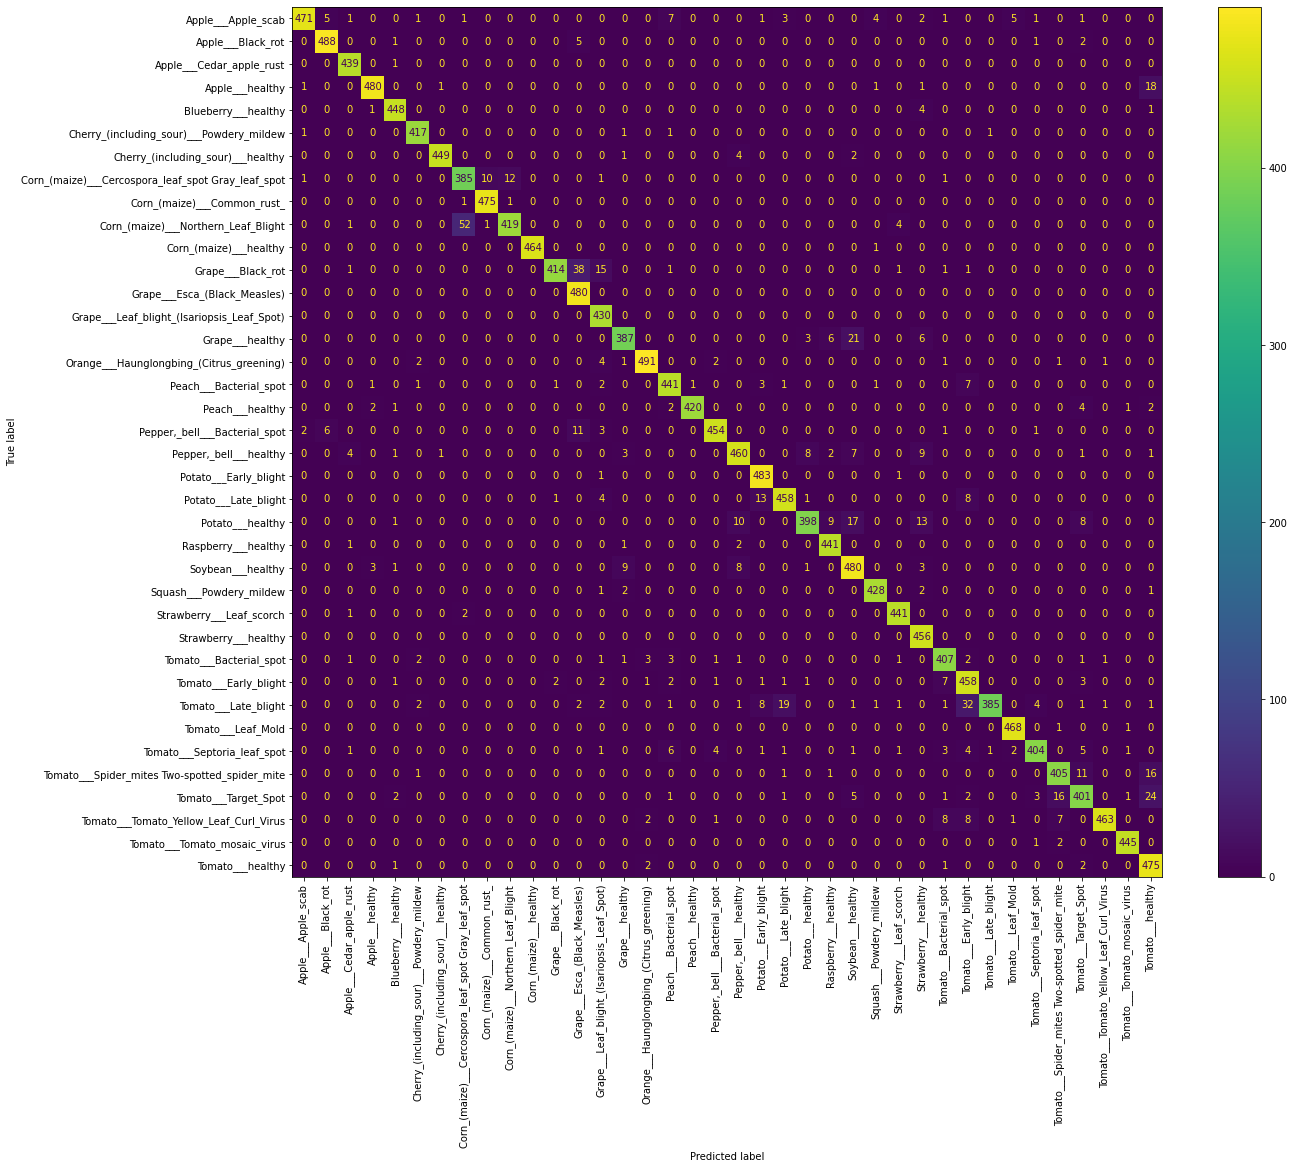

In [51]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                       display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

from tensorflow.keras.models import Sequential ## Saving the model

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model.save('models2')

AttributeError: 'ellipsis' object has no attribute 'save'